In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CEVAE import *
from cevaetools import *
%load_ext autoreload
%autoreload 2

In [2]:
twins_t = pd.read_csv("data/Twins/twin_pairs_T_3years_samesex.csv")
twins_x = pd.read_csv("data/Twins/twin_pairs_X_3years_samesex.csv")
twins_y = pd.read_csv("data/Twins/twin_pairs_Y_3years_samesex.csv")

In [3]:
twins_chosen = (twins_t.dbirwt_0 < 2000) & (twins_t.dbirwt_1 < 2000)

In [4]:
proto_proxy = pd.get_dummies(twins_x[twins_chosen].gestat10)
error = 0.2
proxy1 = ((np.random.random((proto_proxy.shape)) < error) + proto_proxy)%2
proxy2 = ((np.random.random((proto_proxy.shape)) < error) + proto_proxy)%2
proxy3 = ((np.random.random((proto_proxy.shape)) < error) + proto_proxy)%2

In [5]:
proxies = pd.concat([proxy1, proxy2, proxy3], 1)
proxies.columns = ['x'+str(i) for i in range(30)]
proxies

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29
9,0,1,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,1,0,0,1
14,1,1,1,1,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
15,1,0,0,1,0,0,1,0,0,0,...,0,1,0,1,1,0,1,1,0,0
16,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
23,0,1,0,1,0,1,1,1,0,1,...,0,1,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71297,1,0,1,0,0,0,0,1,0,0,...,1,0,1,0,1,0,0,0,1,0
71303,0,1,0,0,0,0,1,0,1,0,...,1,1,0,0,1,0,0,0,0,1
71307,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
71310,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [6]:
twins_x.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'pldel', 'birattnd', 'brstate',
       'stoccfipb', 'mager8', 'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir',
       'mpre5', 'adequacy', 'orfath', 'frace', 'birmon', 'gestat10', 'csex',
       'anemia', 'cardiac', 'lung', 'diabetes', 'herpes', 'hydra', 'hemo',
       'chyper', 'phyper', 'eclamp', 'incervix', 'pre4000', 'preterm', 'renal',
       'rh', 'uterine', 'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5',
       'crace', 'data_year', 'nprevistq', 'dfageq', 'feduc6', 'infant_id_0',
       'infant_id_1', 'dlivord_min', 'dtotord_min', 'bord_0', 'bord_1',
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg'],
      dtype='object')

In [7]:
X = twins_x.copy()[twins_chosen]
X.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'gestat10', 'infant_id_0', 'infant_id_1',
               'bord_0','bord_1','data_year'], inplace=True)
X.fillna(value=X.mean(), inplace=True)

In [8]:
z = twins_x[['gestat10']].copy()[twins_chosen]
z.columns = ['z']

In [19]:
#Choose the t
w0 = np.random.randn(46)*0.1
wh = np.random.randn(1)*0.1+5

In [22]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [23]:
t = (np.random.rand(X.shape[0]) < sigmoid(np.sum(w0*X,1) + wh*(z.squeeze()/10-0.1))).astype(int)
t = pd.DataFrame(t, index=proxies.index, columns=['t'])
yf = (pd.get_dummies(t['t']).to_numpy() * twins_y.iloc[:,1:][twins_chosen].to_numpy()).sum(1)
yf = pd.DataFrame(yf, index=proxies.index, columns=['y'])
ycf = ((1-pd.get_dummies(t).to_numpy()) * twins_y.iloc[:,1:][twins_chosen].to_numpy()).sum(1)

In [24]:
y = twins_y.iloc[:,1:][twins_chosen].to_numpy()
y.mean(0)

array([0.18941923, 0.16421896])

In [25]:
df = pd.concat([proxies, z, t, yf],1)

In [26]:
true_py_dot = y.mean(0)
print(true_py_dot)

[0.18941923 0.16421896]


In [385]:
dataset = CEVAEDataset(df)
BATCH_SIZE = 200
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

In [388]:
track_function = lambda model: estimate_model_py_dot(model, 200000)
true_value = true_py_dot
device = 'cpu'

num_epochs=100
lr_start=0.001
lr_end=0.0001
z_dim=10
p_y_zt_nn_layers=3
p_y_zt_nn_width=30
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn_layers=3
p_x_z_nn_width=50
q_z_nn_layers=3
q_z_nn_width=50
t_mode=2
y_mode=2
x_mode=[2]*30
x_dim = len(x_mode)
ty_separate_enc=True
z_mode=0

plot_curves=True
print_logs=True

#train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
#                p_y_zt_nn_layers, p_y_zt_nn_width, 
#                p_t_z_nn_layers, p_t_z_nn_width,
#                p_x_z_nn_layers, p_x_z_nn_width,
#                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
#                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds]

Epoch 0:
Epoch loss: 232612.09399414062
x: 218845.361328125, t: 6634.370643615723, y: 6304.306282043457, kld: 828.055627822876
Epoch 1:
Epoch loss: 212587.46508789062
x: 200890.90893554688, t: 5634.032138824463, y: 5507.320587158203, kld: 555.2016000747681
Epoch 2:
Epoch loss: 211805.64819335938
x: 199160.29516601562, t: 5610.39139175415, y: 4944.498065948486, kld: 2090.465705871582
Epoch 3:
Epoch loss: 211127.76953125
x: 196981.69580078125, t: 5599.928771972656, y: 4700.791164398193, kld: 3845.354236602783
Epoch 4:
Epoch loss: 210644.70947265625
x: 196374.09985351562, t: 5546.601818084717, y: 4661.788669586182, kld: 4062.21883392334
Epoch 5:
Epoch loss: 210348.48608398438
x: 195885.03051757812, t: 5486.933643341064, y: 4574.449989318848, kld: 4402.07149887085
Epoch 6:
Epoch loss: 208995.05346679688
x: 191764.03662109375, t: 5436.5479164123535, y: 4431.042495727539, kld: 7363.425437927246
Epoch 7:
Epoch loss: 207886.97705078125
x: 188475.01831054688, t: 5416.6041831970215, y: 4387.2094

Epoch loss: 205387.39306640625
x: 183228.36401367188, t: 5342.787528991699, y: 4099.599925994873, kld: 12716.641098022461
Epoch 64:
Epoch loss: 205313.70751953125
x: 183217.04516601562, t: 5360.094158172607, y: 4046.1550521850586, kld: 12690.412658691406
Epoch 65:
Epoch loss: 205216.4619140625
x: 183127.61840820312, t: 5353.387462615967, y: 4029.6514053344727, kld: 12705.803115844727
Epoch 66:
Epoch loss: 205544.14111328125
x: 183250.26391601562, t: 5349.318809509277, y: 4042.603660583496, kld: 12901.955810546875
Epoch 67:
Epoch loss: 205314.52124023438
x: 183138.32934570312, t: 5362.336273193359, y: 4037.4890098571777, kld: 12776.366287231445
Epoch 68:
Epoch loss: 205353.17260742188
x: 183122.10717773438, t: 5383.169380187988, y: 4024.3639488220215, kld: 12823.532760620117
Epoch 69:
Epoch loss: 205588.03491210938
x: 183142.2236328125, t: 5402.884307861328, y: 4138.75887298584, kld: 12904.16764831543
Epoch 70:
Epoch loss: 205418.43823242188
x: 183135.9521484375, t: 5399.971309661865, y

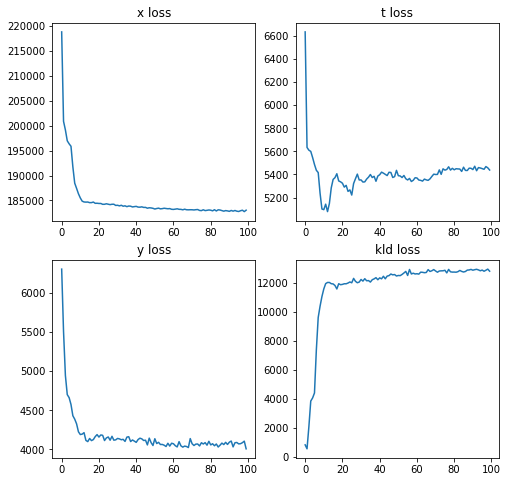

Total loss in the end:  205296.1318359375


In [389]:
model, losses, modelparams = train_model(device, plot_curves, print_logs,
              dataloader, num_epochs, lr_start, lr_end, x_dim, z_dim,
              p_y_zt_nn_layers, p_y_zt_nn_width, 
              p_t_z_nn_layers, p_t_z_nn_width,
              p_x_z_nn_layers, p_x_z_nn_width,
              q_z_nn_layers, q_z_nn_width,
              t_mode, y_mode, x_mode, ty_separate_enc, 
              z_mode, x_loss_scaling=1, common_stds=False, collect_params=False)

In [390]:
estimate_model_py_dot(model)

array([[0.81155905, 0.18844095],
       [0.83873206, 0.16126794]])

In [409]:
from sklearn.ensemble import RandomForestClassifier
x_cols = [c for c in df.columns if c.startswith("x")]
rf = RandomForestClassifier().fit(df[x_cols + ['t']], df['y'])
print(rf.predict(np.concatenate([df[x_cols].to_numpy(), np.zeros(len(df))[:,None]],1)).mean())
print(rf.predict(np.concatenate([df[x_cols].to_numpy(), np.ones(len(df))[:,None]],1)).mean())

0.1764018691588785
0.11874165554072096


In [ ]:
run_model_for_predef_datasets(datasets, param_times, main_folder, sub_folder, BATCH_SIZE, track_function, true_value,
                                  device, train_arguments, labels, data_labels, overwrite=True)

# Actual procedure
## A new bootstrap sampler

In [14]:
twins_chosen = (twins_t.dbirwt_0 < 2000) & (twins_t.dbirwt_1 < 2000)
X = twins_x.copy()[twins_chosen]
X.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'gestat10', 'infant_id_0', 'infant_id_1',
               'bord_0','bord_1','data_year'], inplace=True)
X.fillna(value=X.mean(), inplace=True)

z = twins_x[['gestat10']].copy()[twins_chosen]
z.columns = ['z']

y = twins_y.iloc[:,1:][twins_chosen].to_numpy()
true_py_dot = y.mean(0)

def sample_df(n,X,z,y,w0,wh,error):
    
    proto_proxy = pd.get_dummies(z['z'])
    proxy1 = ((np.random.random((proto_proxy.shape)) < error) + proto_proxy)%2
    proxy2 = ((np.random.random((proto_proxy.shape)) < error) + proto_proxy)%2
    proxy3 = ((np.random.random((proto_proxy.shape)) < error) + proto_proxy)%2
    proxies = pd.concat([proxy1, proxy2, proxy3], 1)
    proxies.columns = ['x'+str(i) for i in range(30)]
    
    t = (np.random.rand(X.shape[0]) < sigmoid(np.sum(w0*X,1) + wh*(z.squeeze()/10-0.1))).astype(int)
    t = pd.DataFrame(t, index=proxies.index, columns=['t'])
    yf = (pd.get_dummies(t['t']).to_numpy() * twins_y.iloc[:,1:][twins_chosen].to_numpy()).sum(1)
    yf = pd.DataFrame(yf, index=proxies.index, columns=['y'])
    ycf = ((1-pd.get_dummies(t).to_numpy()) * twins_y.iloc[:,1:][twins_chosen].to_numpy()).sum(1)
    
    df = pd.concat([proxies, z, t, yf],1)
    
    return df.sample(n, replace=True)

def sigmoid(x):
    return 1/(1+np.exp(-x))

In [18]:
sample_df(10,X,z,y,w0,wh,0.2)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x23,x24,x25,x26,x27,x28,x29,z,t,y
52987,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,3,1,0.0
40321,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,1,1,3,0,0.0
39932,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,3,0,0.0
34912,0,0,0,1,0,1,0,1,1,0,...,1,0,0,1,0,0,0,4,0,0.0
33240,0,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,1,1,2,0,1.0
27999,0,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,4,0,0.0
41035,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0.0
32872,0,0,0,1,1,0,1,1,0,0,...,1,0,0,0,0,0,0,4,1,0.0
14991,0,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,1,0,4,0,0.0
21670,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,1,1,0,3,0,0.0


### Generate and save data generating parameters

In [15]:
main_folder = "twinsdata"

In [16]:
#Choose the t
#w0 = np.random.randn(46)*0.1
#wh = np.random.randn(1)*0.1+5
error = 0.2
sub_folder_params = "genparams1"
#save_dataparameters([w0, wh, error], main_folder, sub_folder_params)

In [21]:
[w0, wh, error] = load_dataparameters(main_folder, sub_folder_params)

### Generate data

In [27]:
# Generate data sets
sub_folder_data = "samplesize1000to10000"
datasize = [1000,2000,3000,5000,10000]
dataparameters = [[num_samples,X,z,y,w0,wh,error] for num_samples in datasize]
generate_df = sample_df
param_times=10
data_labels = list(map(str, datasize))

In [28]:
#dfs, datasets = create_dfs_datasets(generate_df, dataparameters, param_times=10, repeat=False, 
#                    main_folder=main_folder, sub_folder=sub_folder_data, labels=data_labels)

In [29]:
dfs, datasets = load_dfs(main_folder, sub_folder_data, param_times)

### Run model

In [30]:
BATCH_SIZE = 200
track_function = lambda model: estimate_model_py_dot(model, 200000)
true_value = true_py_dot
device = 'cpu'
num_epochs = 400
lr_start=0.001
lr_end=0.0001
z_dim=10
p_y_zt_nn_layers=3
p_y_zt_nn_width=30
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn_layers=3
p_x_z_nn_width=50
q_z_nn_layers=3
q_z_nn_width=50
t_mode=2
y_mode=2
x_mode=np.array([2]*30)
x_dim = len(x_mode)
ty_separate_enc=True
z_mode=0
x_loss_scaling=1
labels = data_labels
common_stds=False

train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds]

sub_folder_model = "samplesize1000to10000_model_zdim10"

In [40]:
# Run the model
models, losses = run_model_for_predef_datasets(datasets, param_times, main_folder, sub_folder_model, 
                                               BATCH_SIZE, track_function, true_value, 
                                               device, train_arguments, labels, data_labels)

Label  30000


KeyboardInterrupt: 

In [30]:
models, losses = load_models_losses(main_folder, sub_folder_model, train_arguments, labels, device)

KeyError: '30000'

In [514]:
pydot1 = np.zeros((param_times, len(labels)))
pydot0 = np.zeros((param_times, len(labels)))
for i,label in enumerate(map(str,labels)):
    print(label)
    for j in range(param_times):
        py_dot = estimate_model_py_dot(models[label][j],n=10000)
        pydot1[j,i] = py_dot[1,1]
        pydot0[j,i] = py_dot[0,1]

1000
2000
3000
5000
10000


In [525]:
true_py_dot

array([0.18941923, 0.16421896])

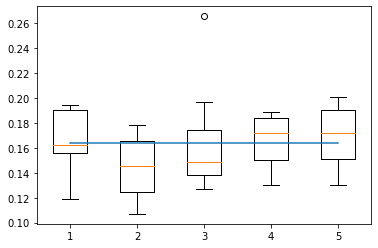

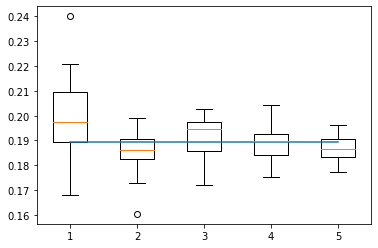

In [527]:
plt.boxplot(pydot1)
plt.plot([1,5],[true_py_dot[1]]*2)
plt.show()

plt.boxplot(pydot0)
plt.plot([1,5],[true_py_dot[0]]*2)
plt.show()

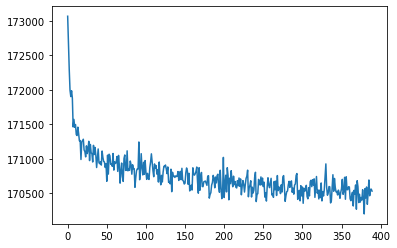

In [533]:
plt.plot(losses['10000'][0]['total'][10:])

### Generate and save data generating parameters

In [41]:
main_folder = "twinsdata"

In [32]:
#Choose the t
w0 = np.random.randn(46)*0.1
wh = np.random.randn(1)*0.1+5
error = 0.2
sub_folder_params = "genparams2"
#save_dataparameters([w0, wh, error], main_folder, sub_folder_params)

Creation of the directory './data/twinsdata/genparams2/ failed. Trying to empty the same folder.


In [42]:
[w0, wh, error] = load_dataparameters(main_folder, sub_folder_params)

### Generate data

In [43]:
# Generate data sets
sub_folder_data = "samplesize1000to30000_genparams2"
datasize = [1000,2000,5000,10000,30000]
dataparameters = [[num_samples,X,z,y,w0,wh,error] for num_samples in datasize]
generate_df = sample_df
param_times=10
data_labels = list(map(str, datasize))

In [44]:
#dfs, datasets = create_dfs_datasets(generate_df, dataparameters, param_times=10, repeat=False, 
#                    main_folder=main_folder, sub_folder=sub_folder_data, labels=data_labels)

In [45]:
# Generate more data
sub_folder_data2 = "samplesize30000to50000_genparams2"
datasize = [30000, 50000]
dataparameters = [[num_samples,X,z,y,w0,wh,error] for num_samples in datasize]
generate_df = sample_df
param_times=10
data_labels = list(map(str, datasize))

In [46]:
#dfs, datasets = create_dfs_datasets(generate_df, dataparameters, param_times=10, repeat=False, 
#                    main_folder=main_folder, sub_folder=sub_folder_data2, labels=data_labels)

In [47]:
dfs, datasets = load_dfs(main_folder, sub_folder_data, param_times)
dfs, datasets = load_dfs(main_folder, sub_folder_data2, param_times)

In [552]:
dfs['30000'][0].t.mean() 
# This should be sensible to not make it unnecessarily difficult ~ and satisfy overlap

0.2034

### Run model

In [51]:
BATCH_SIZE = 500
track_function = lambda model: estimate_model_py_dot(model, 200000)
true_value = true_py_dot
device = 'cpu'
num_epochs = 1000
lr_start=0.004
lr_end=0.0002
z_dim=20
p_y_zt_nn_layers=3
p_y_zt_nn_width=30
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn_layers=3
p_x_z_nn_width=50
q_z_nn_layers=3
q_z_nn_width=50
t_mode=2
y_mode=2
x_mode=np.array([2]*30)
x_dim = len(x_mode)
ty_separate_enc=True
z_mode=0
x_loss_scaling=1
labels = data_labels
common_stds=False
collect_params = 2

train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds, collect_params]

sub_folder_model = "samplesize50000_model_zdim20"

In [52]:
labels[-1:]

['50000']

Creation of the directory './data/twinsdata/samplesize50000_model_zdim20/ failed. Trying to empty the same folder.
Label  50000


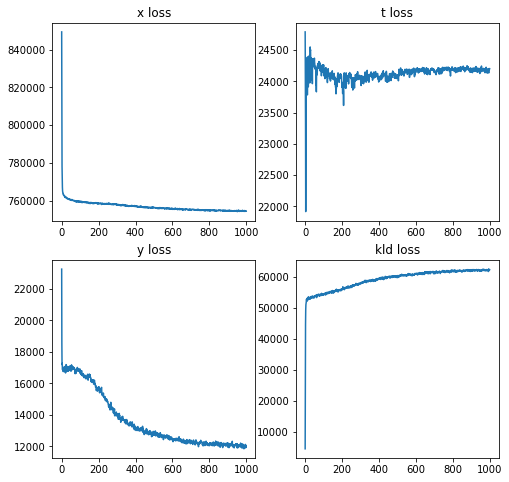

Total loss in the end:  853036.7109375
Estimated causal effect: [[0.8143591  0.1856409 ]
 [0.81113988 0.18886012]] true value: [0.18941923 0.16421896]


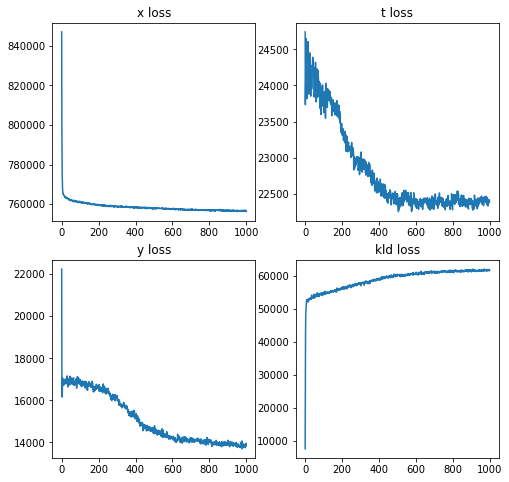

Total loss in the end:  854193.83984375
Estimated causal effect: [[0.82592149 0.17407851]
 [0.81783344 0.18216656]] true value: [0.18941923 0.16421896]


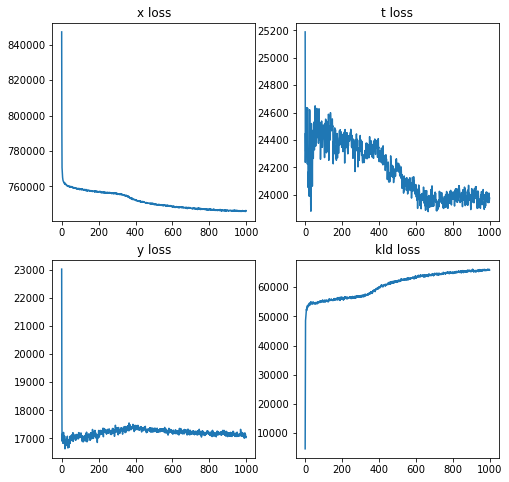

Total loss in the end:  853226.2880859375
Estimated causal effect: [[0.81452084 0.18547916]
 [0.82111488 0.17888512]] true value: [0.18941923 0.16421896]


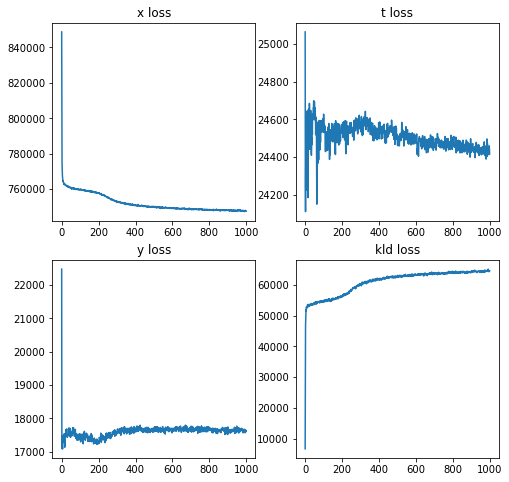

Total loss in the end:  854164.10546875
Estimated causal effect: [[0.81091805 0.18908195]
 [0.83378568 0.16621432]] true value: [0.18941923 0.16421896]


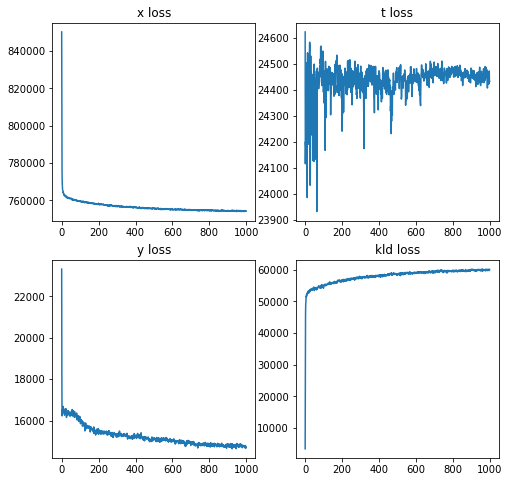

Total loss in the end:  853398.861328125
Estimated causal effect: [[0.80805394 0.19194606]
 [0.82245722 0.17754278]] true value: [0.18941923 0.16421896]


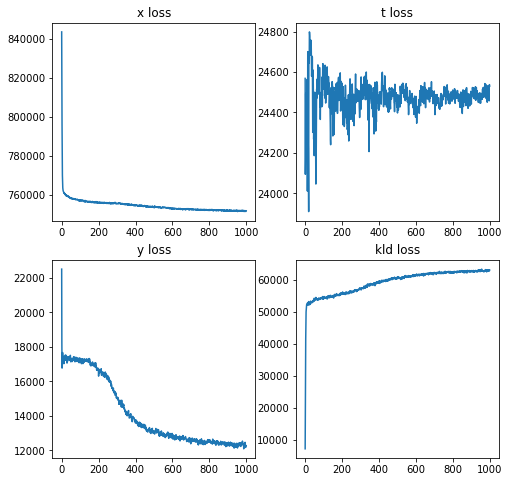

Total loss in the end:  851644.9111328125
Estimated causal effect: [[0.81230859 0.18769141]
 [0.83131592 0.16868408]] true value: [0.18941923 0.16421896]


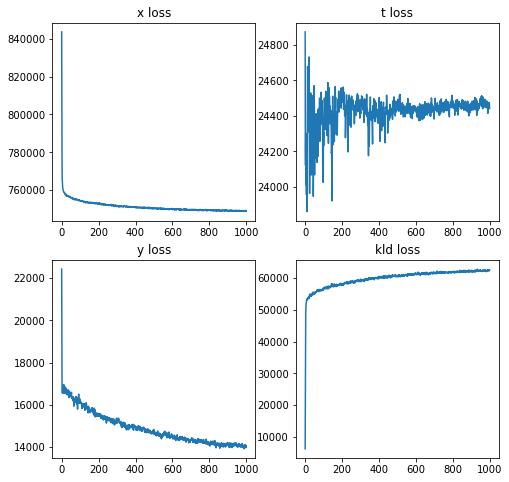

Total loss in the end:  849760.888671875
Estimated causal effect: [[0.8019546  0.1980454 ]
 [0.83396131 0.16603869]] true value: [0.18941923 0.16421896]


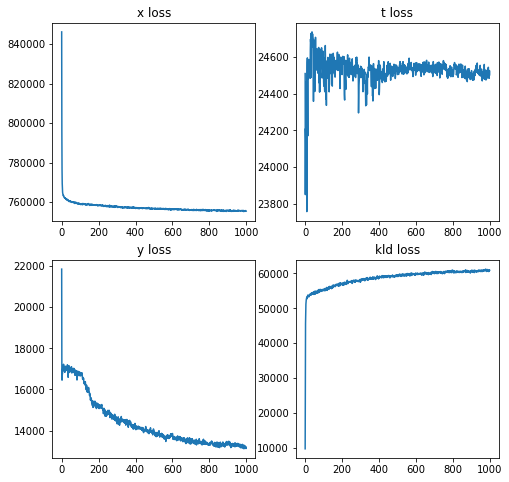

Total loss in the end:  854107.0107421875
Estimated causal effect: [[0.80552387 0.19447613]
 [0.82033816 0.17966184]] true value: [0.18941923 0.16421896]


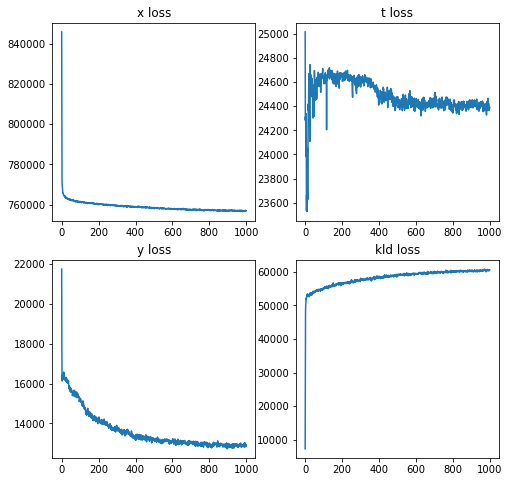

Total loss in the end:  854861.541015625
Estimated causal effect: [[0.81060061 0.18939939]
 [0.83055326 0.16944674]] true value: [0.18941923 0.16421896]


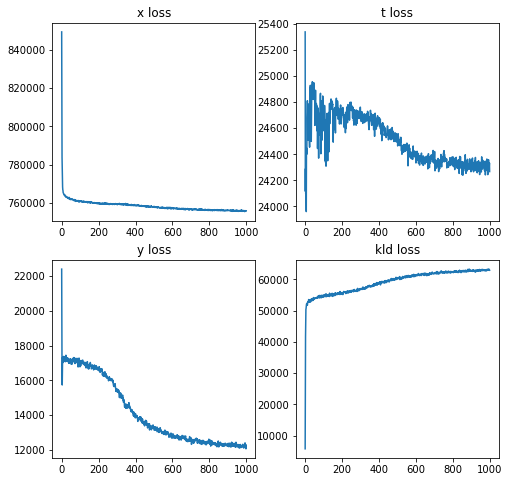

Total loss in the end:  855247.0947265625
Estimated causal effect: [[0.81887169 0.18112831]
 [0.79747298 0.20252702]] true value: [0.18941923 0.16421896]


In [53]:
# Run the model
models, losses = run_model_for_predef_datasets({'50000': datasets['50000']}, param_times, main_folder, sub_folder_model, 
                                               BATCH_SIZE, track_function, true_value, 
                                               device, train_arguments, labels[-1:], data_labels[-1:])

In [590]:
models, losses = load_models_losses(main_folder, sub_folder_model, train_arguments, labels, device)

In [155]:
pydotests = load_saved_params(main_folder, sub_folder_model, labels)

In [563]:
pydot1 = np.zeros((param_times, len(labels)))
pydot0 = np.zeros((param_times, len(labels)))
for i,label in enumerate(map(str,labels)):
    print(label)
    for j in range(param_times):
        py_dot = estimate_model_py_dot(models[label][j],n=10000)
        pydot1[j,i] = py_dot[1,1]
        pydot0[j,i] = py_dot[0,1]

1000
2000
5000
10000
30000


In [604]:
models['30000'].keys()
pydot1_2 = np.zeros((10,1))
pydot0_2 = np.zeros((10,1))
for i,label in enumerate(map(str,labels)):
    print(label)
    for j in range(10):
        py_dot = estimate_model_py_dot(models[label][j],n=10000)
        pydot1_2[j,i] = py_dot[1,1]
        pydot0_2[j,i] = py_dot[0,1]

30000
50000


KeyError: '50000'

In [54]:
pydot1_3 = np.zeros((10,1))
pydot0_3 = np.zeros((10,1))
for i,label in enumerate(map(str,['50000'])):
    print(label)
    for j in range(10):
        py_dot = estimate_model_py_dot(models[label][j],n=10000)
        pydot1_3[j,i] = py_dot[1,1]
        pydot0_3[j,i] = py_dot[0,1]

50000


In [55]:
true_py_dot

array([0.18941923, 0.16421896])

In [65]:
[losses['50000'][i]['y'][-1] for i in range(10)]

[11949.076904296875,
 13869.657585144043,
 17051.722198486328,
 17621.983459472656,
 14717.867553710938,
 12284.090042114258,
 14007.76390838623,
 13198.19287109375,
 12935.462684631348,
 12266.196212768555]

In [144]:
dfs[dsize][dfid][dfs[dsize][dfid].t==0].groupby('z').mean()['y']

z
1     0.859316
2     0.550421
3     0.104451
4     0.045765
5     0.058179
6     0.061863
7     0.130890
8     0.109589
9     0.095785
10    0.148718
Name: y, dtype: float64

In [152]:
dfs[dsize][6].groupby('z').count()['x0'] / len(dfs[dsize][0])

z
1     0.00564
2     0.22838
3     0.32586
4     0.33938
5     0.03040
6     0.04062
7     0.00598
8     0.00346
9     0.00690
10    0.01338
Name: x0, dtype: float64

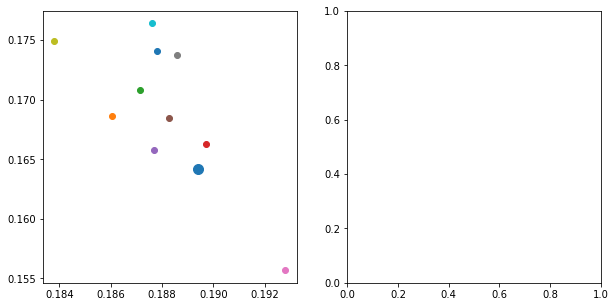

In [143]:
dfid = 5
dsize = '50000'
#yloss = [losses[dsize][i]['total'][-1] for i in range(10)]
fig, ax = plt.subplots(1,2,figsize=(10,5))
for dfid in range(10):
    pydot0est = (dfs[dsize][dfid][dfs[dsize][dfid].t==0].groupby('z').mean()['y'] \
        * dfs[dsize][dfid].groupby('z').count()['x0'] / len(dfs[dsize][dfid])).sum()
    pydot1est = (dfs[dsize][dfid][dfs[dsize][dfid].t==1].groupby('z').mean()['y'] \
        * dfs[dsize][dfid].groupby('z').count()['x0'] / len(dfs[dsize][dfid])).sum()
    ax[0].plot(pydot0est, pydot1est, 'o')
ax[0].plot([true_py_dot[0]],[true_py_dot[1]],'o', markersize=10)

In [163]:
pydotests['50000'][0][i]

array([[0.81184992, 0.18815008],
       [0.82898901, 0.17101099]])

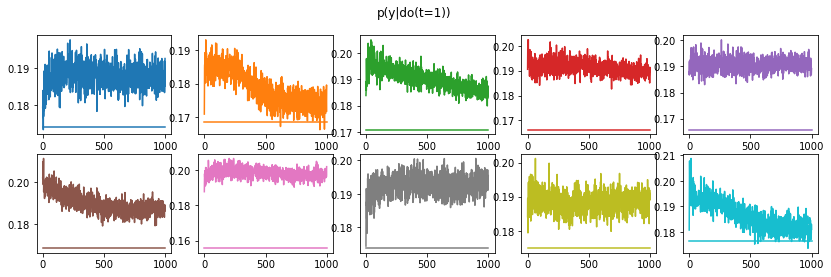

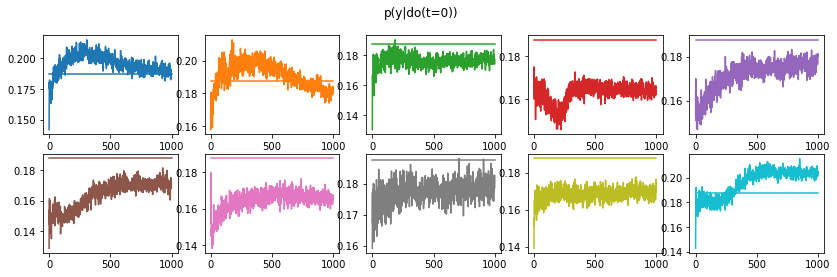

In [183]:
#pydot estimates against the best estimates from the data

fig, ax = plt.subplots(2,5,figsize=(14,4))
plt.suptitle("p(y|do(t=1))")
for j in range(10):
    x,y = j%5,j//5
    ax[y,x].plot([pydotests['50000'][j][i][0,1] for i in range(num_epochs)], color='C'+str(j))
    pydot1est = (dfs[dsize][j][dfs[dsize][j].t==1].groupby('z').mean()['y'] \
        * dfs[dsize][j].groupby('z').count()['x0'] / len(dfs[dsize][j])).sum()
    ax[y,x].plot([0,1000],[pydot1est,pydot1est], color='C'+str(j))
    
fig, ax = plt.subplots(2,5,figsize=(14,4))
plt.suptitle("p(y|do(t=0))")
for j in range(10):
    x,y = j%5,j//5
    ax[y,x].plot([pydotests['50000'][j][i][1,1] for i in range(num_epochs)], color='C'+str(j))
    pydot0est = (dfs[dsize][dfid][dfs[dsize][dfid].t==0].groupby('z').mean()['y'] \
        * dfs[dsize][dfid].groupby('z').count()['x0'] / len(dfs[dsize][dfid])).sum()
    ax[y,x].plot([0,1000],[pydot0est,pydot0est], color='C'+str(j))

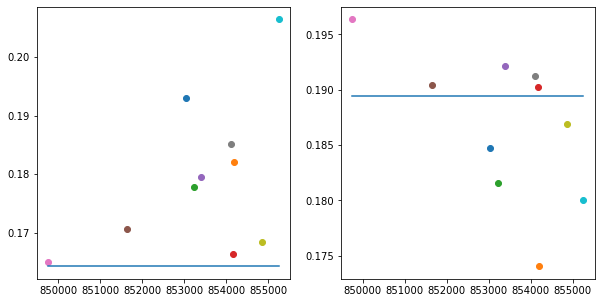

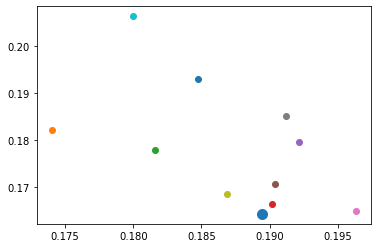

In [184]:
pydot1_3
yloss = [losses['50000'][i]['total'][-1] for i in range(10)]
fig, ax = plt.subplots(1,2,figsize=(10,5))
for i in range(10):
    ax[0].plot(yloss[i], pydot1_3[i], 'o')
    ax[1].plot(yloss[i], pydot0_3[i], 'o')
ax[0].plot([min(yloss),max(yloss)],[true_py_dot[1],true_py_dot[1]])
ax[1].plot([min(yloss),max(yloss)],[true_py_dot[0],true_py_dot[0]])
plt.figure()
for i in range(10):
    plt.plot(pydot0_3[i], pydot1_3[i], 'o')
plt.plot([true_py_dot[0]],[true_py_dot[1]],'o', markersize=10)

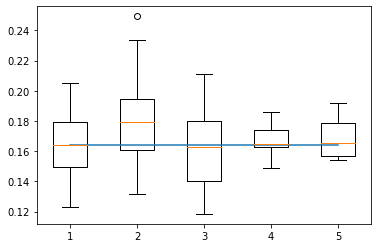

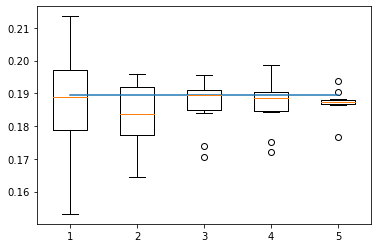

In [564]:
plt.boxplot(pydot1)
plt.plot([1,5],[true_py_dot[1]]*2)
plt.show()

plt.boxplot(pydot0)
plt.plot([1,5],[true_py_dot[0]]*2)
plt.show()

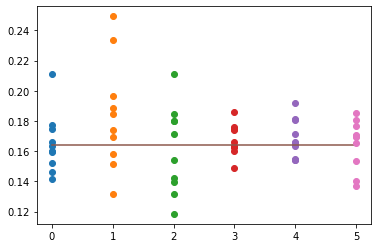

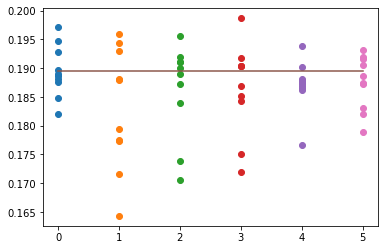

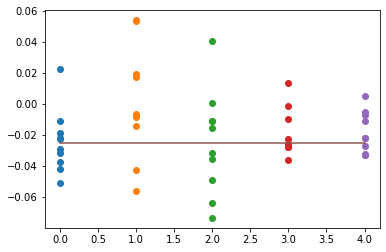

In [627]:
for i in range(5):
    plt.plot([i]*param_times,pydot1[:,i],'o')
plt.plot([0,5],[true_py_dot[1]]*2)
plt.plot([5]*10, pydot1_3, 'o')

plt.show()

for i in range(5):
    plt.plot([i]*param_times,pydot0[:,i],'o')
plt.plot([0,5],[true_py_dot[0]]*2)
plt.plot([5]*10, pydot0_3, 'o')
plt.show()



for i in range(5):
    plt.plot([i]*param_times,pydot1[:,i]-pydot0[:,i],'o')
plt.plot([0,4],[true_py_dot[1]-true_py_dot[0]]*2)


plt.show()

# Test with 50000 data points, one data set

In [31]:
sub_folder_data2 = "samplesize30000to50000_genparams2"
datasize = [30000, 50000]
dataparameters = [[num_samples,X,z,y,w0,wh,error] for num_samples in datasize]
generate_df = sample_df
param_times=10
data_labels = list(map(str, datasize))
dfs, datasets = load_dfs(main_folder, sub_folder_data2, param_times)

In [32]:
datasets = {'50000':{d:datasets['50000'][0] for d in datasets['50000'].keys()}}
datasets

{'50000': {0: <cevaetools.CEVAEDataset at 0x192bb94efc8>,
  1: <cevaetools.CEVAEDataset at 0x192bb94efc8>,
  2: <cevaetools.CEVAEDataset at 0x192bb94efc8>,
  3: <cevaetools.CEVAEDataset at 0x192bb94efc8>,
  4: <cevaetools.CEVAEDataset at 0x192bb94efc8>,
  5: <cevaetools.CEVAEDataset at 0x192bb94efc8>,
  6: <cevaetools.CEVAEDataset at 0x192bb94efc8>,
  7: <cevaetools.CEVAEDataset at 0x192bb94efc8>,
  8: <cevaetools.CEVAEDataset at 0x192bb94efc8>,
  9: <cevaetools.CEVAEDataset at 0x192bb94efc8>}}

In [33]:
datasets['50000'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [35]:
BATCH_SIZE = 500
track_function = lambda model: estimate_model_py_dot(model, 200000)
true_value = true_py_dot
device = 'cpu'
num_epochs = 1500
lr_start=0.004
lr_end=0.0002
z_dim=20
p_y_zt_nn_layers=3
p_y_zt_nn_width=30
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn_layers=3
p_x_z_nn_width=50
q_z_nn_layers=3
q_z_nn_width=50
t_mode=2
y_mode=2
x_mode=np.array([2]*30)
x_dim = len(x_mode)
ty_separate_enc=True
z_mode=0
x_loss_scaling=1
labels = data_labels
common_stds=False
collect_params = 2

train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds, collect_params]

sub_folder_model = "samplesize50000_0_model_zdim20"

Creation of the directory './data/twinsdata/samplesize50000_0_model_zdim20/ failed. Trying to empty the same folder.
Label  50000


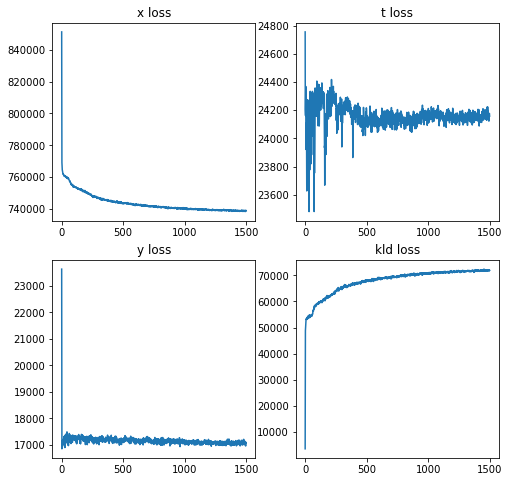

Total loss in the end:  852123.7802734375
Estimated causal effect: [[0.81352875 0.18647125]
 [0.82689737 0.17310263]] true value: [0.18941923 0.16421896]


In [ ]:
# Run the model
models, losses = run_model_for_predef_datasets(datasets, param_times, main_folder, sub_folder_model, 
                                               BATCH_SIZE, track_function, true_value, 
                                               device, train_arguments, labels[-1:], data_labels[-1:])

In [36]:
models, losses = load_models_losses(main_folder, sub_folder_model, train_arguments[:-1], labels, device)
pydotests = load_saved_params(main_folder, sub_folder_model, labels)

In [197]:
pydot1_3 = np.zeros((10,1))
pydot0_3 = np.zeros((10,1))
for i,label in enumerate(map(str,['50000'])):
    print(label)
    for j in range(10):
        py_dot = estimate_model_py_dot(models[label][j],n=10000)
        pydot1_3[j,i] = py_dot[1,1]
        pydot0_3[j,i] = py_dot[0,1]

50000


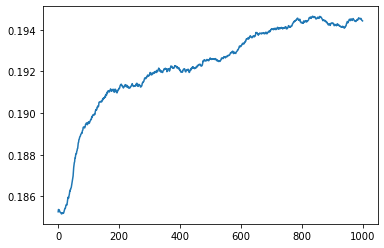

In [212]:
from scipy.ndimage.filters import uniform_filter1d

plt.plot(uniform_filter1d(np.array([pydotests['50000'][j][i][0,1]\
                            for i in range(num_epochs)]), size=100),color='C'+str(j))

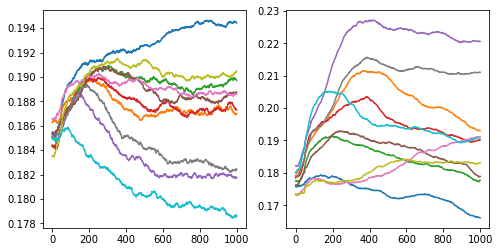

In [217]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
for j in range(10):
    ax[0].plot(uniform_filter1d(np.array([pydotests['50000'][j][i][0,1]\
                            for i in range(num_epochs)]), size=100),color='C'+str(j))
    ax[1].plot(uniform_filter1d(np.array([pydotests['50000'][j][i][1,1]\
                            for i in range(num_epochs)]), size=100),color='C'+str(j))

In [38]:
true_py_dot

array([0.18941923, 0.16421896])

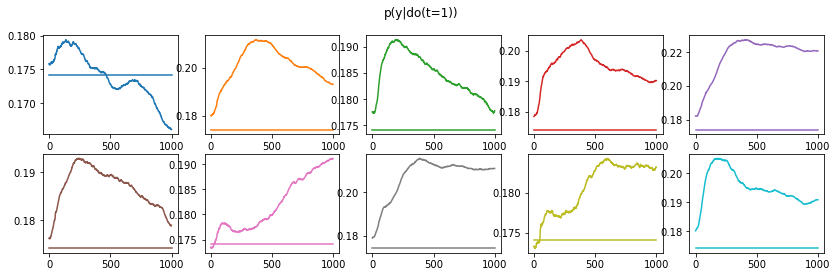

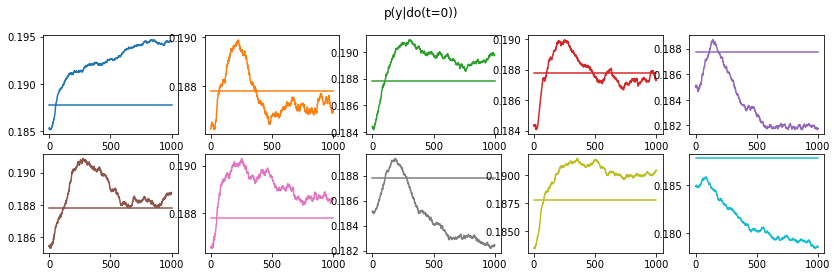

In [221]:
#pydot estimates against the best estimates from the data

fig, ax = plt.subplots(2,5,figsize=(14,4))
dsize='50000'
plt.suptitle("p(y|do(t=1))")
for j in range(10):
    x,y = j%5,j//5
    ax[y,x].plot(uniform_filter1d(np.array([pydotests['50000'][j][i][1,1]\
                            for i in range(num_epochs)]), size=100),color='C'+str(j))
    pydot1est = (dfs[dsize][0][dfs[dsize][0].t==1].groupby('z').mean()['y'] \
        * dfs[dsize][0].groupby('z').count()['x0'] / len(dfs[dsize][0])).sum()
    ax[y,x].plot([0,1000],[pydot1est,pydot1est], color='C'+str(j))
    
fig, ax = plt.subplots(2,5,figsize=(14,4))
plt.suptitle("p(y|do(t=0))")
for j in range(10):
    x,y = j%5,j//5
    ax[y,x].plot(uniform_filter1d(np.array([pydotests['50000'][j][i][0,1]\
                            for i in range(num_epochs)]), size=100),color='C'+str(j))
    pydot0est = (dfs[dsize][0][dfs[dsize][0].t==0].groupby('z').mean()['y'] \
        * dfs[dsize][0].groupby('z').count()['x0'] / len(dfs[dsize][0])).sum()
    ax[y,x].plot([0,1000],[pydot0est,pydot0est], color='C'+str(j))